In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb
import numpy as np

In [2]:
datasig=pd.read_csv("sig_lep_values.csv")
databkg=pd.read_csv("bkg_lep_values.csv")
databkg["label"]=0
datasig["label"]=1

data2=datasig.append(databkg,ignore_index=True)

In [3]:
data2.shape
data2.tail()

,LepPt[0],LepPt[1],LepPt[2],LepPt[3],LepPhi[0],LepPhi[1],LepPhi[2],LepPhi[3],LepEta[0],LepEta[1],...,JetPt2,JetEta2,JetPhi2,JetMass2,JetBTagger2,ExtraLepPt1,ExtraLepPhi1,ExtraLepEta1,weight,label
7496,24.1909,162.7460,31.86730,35.5269,0.031161,-1.084870,-0.217913,-0.499708,-1.909610,-1.101370,...,75.8137,-1.178490,1.956440,9.03298,0.012424,14.1714,-2.137100,0.452280,0.000072,0
7497,105.2850,70.9915,12.10000,81.3316,0.189115,1.287100,0.743165,0.675071,1.055390,0.947068,...,114.9940,1.672570,-0.964091,17.91020,0.447669,28.6112,2.690080,-1.739000,0.000060,0
7498,77.0213,28.6309,11.71160,23.4228,-0.093287,1.730390,0.782272,0.429178,-0.129361,-1.161710,...,97.1350,-1.982220,-0.242977,14.21610,0.028420,24.3353,-3.068540,-0.716765,0.000087,0
7499,64.4011,28.3313,11.23500,17.3998,0.510646,-2.510480,-1.752650,-0.519232,0.477086,1.421940,...,106.0060,1.001600,1.277150,9.72068,0.016652,24.2179,-1.189860,0.130914,0.000061,0
7500,38.7214,14.7357,8.19858,15.9957,-2.314250,0.011534,-2.259060,-0.274397,-1.702020,0.796134,...,63.3445,-0.523344,0.697050,9.36421,0.935571,27.3380,-0.548966,-1.505040,0.000018,0


In [4]:
X,Y=data2.iloc[:,:-2],data2.iloc[:,-1]
weights=data2.iloc[:,-2]
X_train, X_test, y_train, y_test,weight_train,weight_test= train_test_split(X, Y,weights,test_size=0.3, random_state=7)

In [5]:
weight_train=weight_train*10**2
weight_test=weight_test*10**2
weight_train=np.asarray(weight_train)
weight_test=np.asarray(weight_test)
y_test=np.asarray(y_test)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
X_train=np.asarray(X_train)


In [6]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=weight_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.28%


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

AUC: 0.653


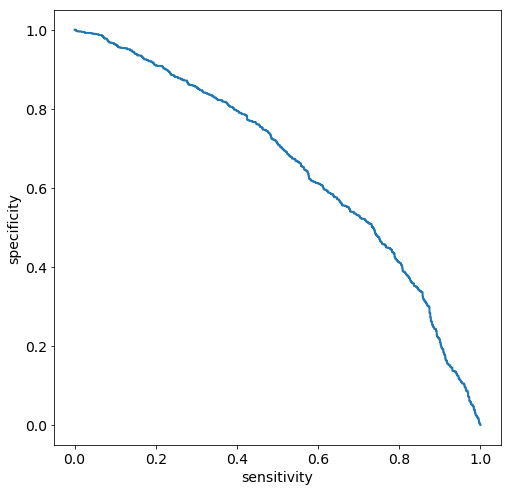

In [8]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs,sample_weight=weight_test)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs,sample_weight=weight_test)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(tpr, 1-fpr,linewidth=2)
# show the plot
plt.xlabel("sensitivity",fontsize=14)
plt.ylabel("specificity",fontsize=14)
plt.tick_params(axis="both",labelsize=14)
plt.show()

In [9]:
probs

array([0.47499353, 0.53693354, 0.3754518 , ..., 0.3916656 , 0.63618773,
       0.5343042 ], dtype=float32)

In [10]:
for kk in range(tpr.size):
    if(round(tpr[kk],3)==0.400):
        speci=1-fpr[kk]
        print(speci)

0.7957515018894119
0.7945223014736797


In [11]:
filename="xgboost_lep.CSV"
with open(filename,"w") as file:
    for kk in range(tpr.size):
        file.write(str(fpr[kk]))
        file.write(" ")
        file.write(str(tpr[kk]))
        file.write("\n")

In [12]:
fpr.size

2252

In [13]:
tpr.size

2252

In [14]:
sig_probs=[]
bkg_probs=[]
sig_weight=[]
bkg_weight=[]
for index in range(y_test.shape[0]):
    if(y_test[index]==1.0):
        sig_probs.append(probs[index])
        sig_weight.append(weight_test[index])
    else:
        bkg_probs.append(probs[index])
        bkg_weight.append(weight_test[index])

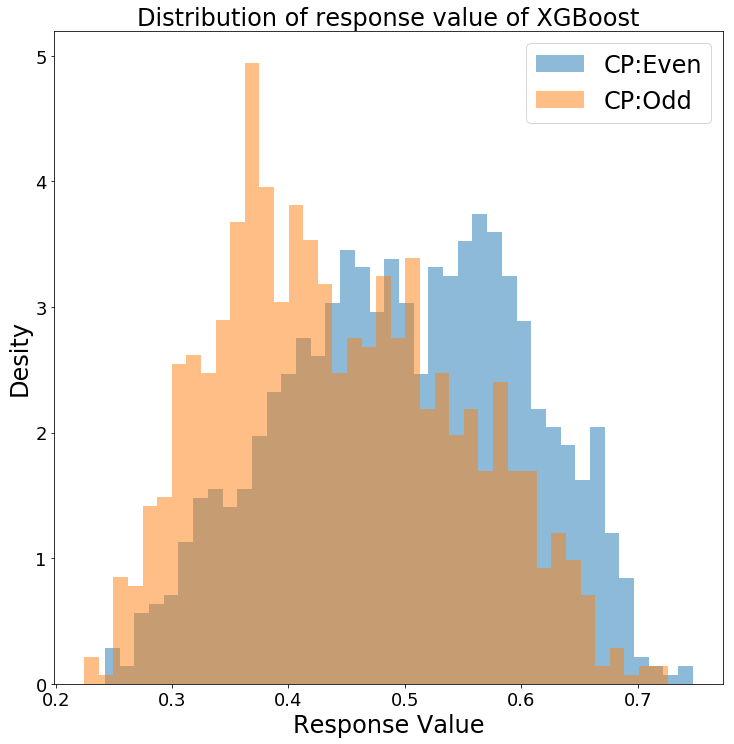

In [17]:
plt.figure(3)
plt.rcParams['figure.figsize'] = [12, 12]

plt.hist(sig_probs,bins=40,density=True,alpha=0.5,label="CP:Even");
plt.hist(bkg_probs,bins=40,density=True,alpha=0.5,label="CP:Odd");
plt.legend(loc='upper right',fontsize=24)
plt.title("Distribution of response value of XGBoost",fontsize=24)
plt.xlabel("Response Value",fontsize=24)
plt.ylabel("Desity",fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('xgboost_lep_output.png')
plt.show()

In [16]:
from ROOT import TFile, TH1F
file=TFile("xgboost_lep_hist.root","RECREATE")
h1=TH1F("sig","histo of signal",40,0,1)
h2=TH1F("bkg","histo of background",40,0,1)
for kk in range(len(sig_probs)):
    h1.Fill(sig_probs[kk],sig_weight[kk])
for kk in range(len(bkg_probs)):
    h2.Fill(bkg_probs[kk],bkg_weight[kk])
inte1=h2.Integral("width")
scale1=1/h1.Integral("width")
scale2=1/h2.Integral("width")
h1.Scale(scale1)
h2.Scale(scale2)
file.Write();

Welcome to JupyROOT 6.19/01
